### 1. Импорт библиотек и подготовка датафрейма:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from ipywidgets import interact, widgets
from prophet import Prophet
from pandas.tseries.offsets import MonthEnd

In [2]:
# Создаем список товаров
products = ['alpha', 'bravo', 'charlie']

# Создаем список дат с равномерным распределением продаж в течение года
dates = pd.date_range(start='2013-01-01', end='2023-12-31', freq='D')

# Создаем пустой список для хранения данных
data = []

# Заполняем список данных
for date in dates:
    # Определяем сезон по месяцу
    if date.month in [12, 1, 2]:  # Зима
        season = 0
    elif date.month in [3, 4, 5]:  # Весна
        season = 1
    elif date.month in [6, 7, 8]:  # Лето
        season = 2
    else:  # Осень
        season = 3
    
    # Определяем диапазон продаж для каждого товара в зависимости от сезона
    for product in products:
        if product == 'alpha':
            if season == 0:  # Зима
                sales_range = (5, 10)
            elif season == 1:  # Весна
                sales_range = (20, 30)
            elif season == 2:  # Лето
                sales_range = (20, 50)
            else:  # Осень
                sales_range = (5, 10)
        elif product == 'bravo':
            if season == 0:  # Зима
                sales_range = (10, 10)
            elif season == 1:  # Весна
                sales_range = (10, 10)
            elif season == 2:  # Лето
                sales_range = (35, 35)
            else:  # Осень
                sales_range = (10, 10)
        elif product == 'charlie':
            if season == 0:  # Зима
                sales_range = (5, 5)
            elif season == 1:  # Весна
                sales_range = (5, 5)
            elif season == 2:  # Лето
                sales_range = (5, 5)
            else:  # Осень
                sales_range = (5, 5)
        
        # Генерируем случайное количество продаж в этот день
        sales_count = random.randint(*sales_range)
        
        # Добавляем строки в список данных
        for _ in range(sales_count):
            data.append({'product': product, 'sale_date': date})

# Создаем датафрейм из списка данных
df = pd.DataFrame(data)
df['price'] = df.apply(lambda row: random.randint(1, 5), axis=1)

# Выводим датафрейм
df

,product,sale_date,price
0,alpha,2013-01-01,4
1,alpha,2013-01-01,4
2,alpha,2013-01-01,3
3,alpha,2013-01-01,5
4,alpha,2013-01-01,4
...,...,...,...
161245,charlie,2023-12-31,5
161246,charlie,2023-12-31,5
161247,charlie,2023-12-31,3
161248,charlie,2023-12-31,2


### 2. Задания к датафрейму:

1) Вывести на график данные с характерным сезоным очертанием.
2) Проверить эффективность прогнозирования на данных с характерным сезоным очертанием.

#### 1. Вывести на график данные с характерным сезоным очертанием.

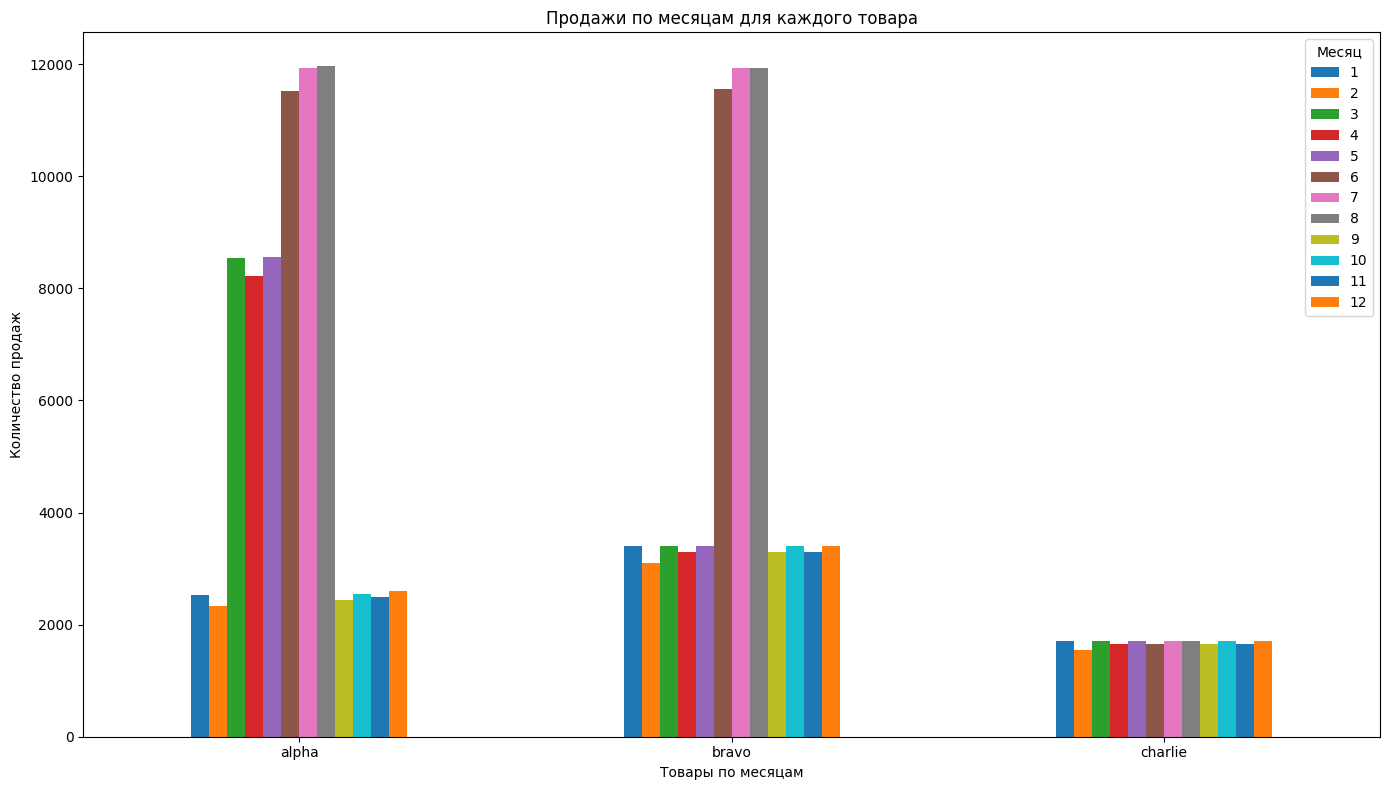

In [3]:
# Преобразуем столбец Sale_Date в формат даты
df['sale_date'] = pd.to_datetime(df['sale_date'])

# Создаем новый столбец Month, содержащий номера месяцев
df['month'] = df['sale_date'].dt.month

# Группируем данные по товару и месяцу и считаем количество продаж
monthly_sales = df.groupby(['product', 'month']).size().unstack()

# Строим график
monthly_sales.plot(kind='bar', figsize=(14, 8))
plt.title('Продажи по месяцам для каждого товара')
plt.xlabel('Товары по месяцам')
plt.ylabel('Количество продаж')
plt.xticks(rotation=0)
plt.legend(title='Месяц')
plt.tight_layout()
plt.show()

Другой вид графика тех же данных:

In [4]:
# Создаем копию DataFrame для безопасной работы
df_copy = df.copy()

# Преобразовываем столбец 'sale_date' в формат даты
df_copy['sale_date'] = pd.to_datetime(df_copy['sale_date'])

# Создаем новый столбец 'sale_month', содержащий месяц продажи
df_copy['sale_month'] = df_copy['sale_date'].dt.to_period('M')

# Получаем список всех продуктов
all_products = df_copy['product'].unique()

def plot_product_sales(product):
    # Создаем копию DataFrame с данными только для выбранного продукта
    df_product = df_copy[df_copy['product'] == product]
    
    # Группируем данные по месяцам и суммируем продажи
    monthly_sales = df_product.groupby('sale_month')['price'].sum()
    
    # Строим график
    plt.figure(figsize=(14, 8))
    monthly_sales.plot(marker='o')
    plt.title(f'Динамика продаж товара "{product}" по месяцам')
    plt.xlabel('Месяц и год')
    plt.ylabel('Сумма продаж')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Создаем виджет для выбора продукта из списка всех продуктов
product_dropdown = widgets.Dropdown(options=all_products, description='Product:')

# Используем функцию interact для связывания виджета с функцией построения графика
interact(plot_product_sales, product=product_dropdown);


interactive(children=(Dropdown(description='Product:', options=('alpha', 'bravo', 'charlie'), value='alpha'), …

#### 2. Проверить эффективность прогнозирования на данных с характерным сезоным очертанием.

In [5]:
# Функция для построения графика
def plot_sales(product):
    # Создаем копию DataFrame для предотвращения изменений исходного DataFrame
    df_copy = df.copy()
    
    df_product = df_copy[df_copy['product'] == product]
    # Используем .loc для изменения копии
    df_product.loc[:, 'sale_date'] = pd.to_datetime(df_product['sale_date'])
    df_product.set_index('sale_date', inplace=True)
    
    # Определение начальной и конечной даты для обучения модели
    start_date = df_product.index.min() + pd.offsets.MonthBegin(1)  # Первый день следующего месяца
    end_date = df_product.index.max() - MonthEnd(1)  # Последний день предпоследнего месяца
    
    # Обрезка датафрейма
    df_product = df_product[start_date:end_date]
    
    # Преобразование данных для использования с Prophet
    df_prophet = df_product.resample('M').size().reset_index()
    df_prophet.columns = ['ds', 'y']
    
    # Создание и обучение модели Prophet
    model = Prophet()
    model.fit(df_prophet)
    
    # Создание DataFrame для прогноза
    future = model.make_future_dataframe(periods=12, freq='M')
    forecast = model.predict(future)
    
    # Фильтрация прогноза, чтобы показать только следующий месяц
    next_month_forecast = forecast.loc[forecast['ds'] > df_prophet['ds'].max()]
    
    # Построение графика
    plt.figure(figsize=(14, 8))
    
    # Отображение фактических данных за весь период
    plt.plot(df_prophet['ds'],
             df_prophet['y'],
             marker='o',
             label='Исходные данные')
    
    # Отображение прогноза следующего месяца
    plt.plot(next_month_forecast['ds'],
             next_month_forecast['yhat'],
             linestyle='--',
             color='red',
             marker='o',
             label='Прогноз')
    
    plt.title(f'Сумма продаж в {product} по месяцам с прогнозом')
    plt.xlabel('Месяц и год')
    plt.ylabel('Сумма продаж')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Создание выпадающего списка для выбора места продаж
df_product_widget = widgets.Dropdown(
    options=df_copy['product'].unique().tolist(),
    description='product:',
)

# Вызов функции построения графика при изменении значения выпадающего списка
interact(plot_sales, product=df_product_widget)

interactive(children=(Dropdown(description='product:', options=('alpha', 'bravo', 'charlie'), value='alpha'), …

<function __main__.plot_sales(product)>

Видно что метод Prophet отлично повторяет сезонность данных для прогнозирования.